# Deep Learning for Image Classification

In this notebook we will be implementing an image classifier using a deep learning framework.

The dataset we will be using is the Fashion MNIST dataset.

According to the [TensorFlow docs](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data), this is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 

The classes are:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

## Preamble

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tensorflow.keras import datasets, layers, models, Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf


2024-08-04 22:16:50.466752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Part 1: Explore Data

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
print(f'Training data set shape: {x_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing set shape: {x_test.shape}')
print(f'Testing labels shape: {y_test.shape}')

Training data set shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing set shape: (10000, 28, 28)
Testing labels shape: (10000,)


In [3]:
# create list of class names in the order of their labels
class_names = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat', 
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

In [4]:
# look at the first item in the training dataset
print(x_train[0])
print()
print(f"Shape of item at index 0: {x_train[0].shape}")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

The images have a shape of 28 by 28 pixels, each containing a number that ranges from 0 to 255.

Next, we'll visualize them.

In [5]:
# helper function to display individual image
def show_indiv_image(df, idx, label_idx, cmap=None):
    plt.figure(figsize=(4,4))
    plt.imshow(df[idx], cmap=cmap)
    plt.colorbar()
    plt.grid(False)
    plt.title(f'Image Label: {class_names[label_idx]}')
    plt.show()

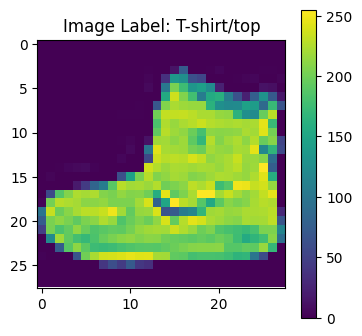

In [6]:
show_indiv_image(x_train, 0, 0)

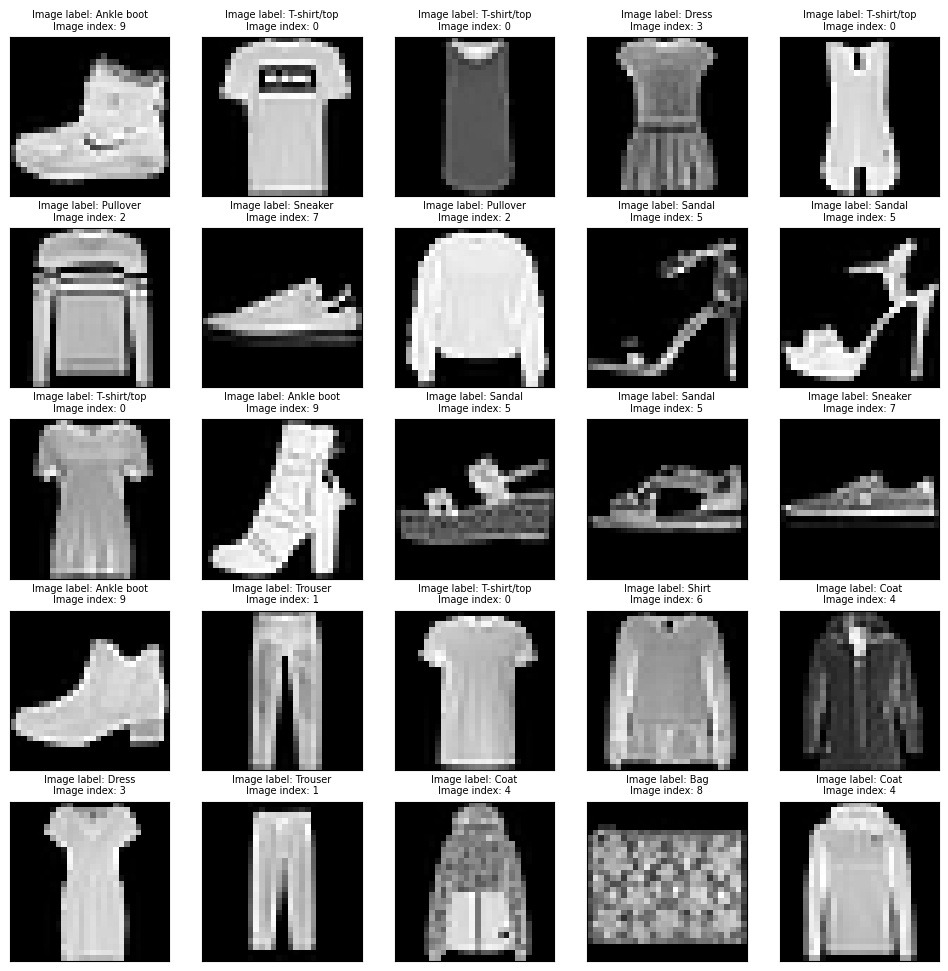

array([9, 0, 0, 3, 0], dtype=uint8)

In [7]:
# visualize the first 25 fashion pieces in grayscale
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Image label: {class_names[y_train[i]]}\nImage index: {y_train[i]}", fontsize=7)
plt.show()

y_train[:5]

Looking at the first 5 items (top row) in the `y_train` dataset which stores the target variable, we see that they are correspond to the images:
1. Shoe
2. Top
3. Top 
4. Dress
5. Top

Finally, we conclude this section with the number of value counts for each label:

In [8]:
print(f'Training set labels:\n{pd.Series(y_train).value_counts()}')
print()
print(f'Test set labels:\n{pd.Series(y_test).value_counts()}')

Training set labels:
9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
Name: count, dtype: int64

Test set labels:
9    1000
2    1000
1    1000
6    1000
4    1000
5    1000
7    1000
3    1000
8    1000
0    1000
Name: count, dtype: int64


The number of labels are evenly distributed in both the training and test sets. Each of the 10 unique labels are equally represented - making up 10% of the training and test sets.

## Part 2: Preprocessing

Because we'll be training a neural network for our image classifier, we'll need to normalize the image data so that it ranges within 0 to 1.

We can do this by dividing the pixels by the maximum number in the dataset, 255.

In [9]:
# normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

When we display the image of the first item again, everything looks the same other than the color map on the right.

It now ranges from 0 to 1 whereas prior to the normalization, it ranged from 0 to 255.

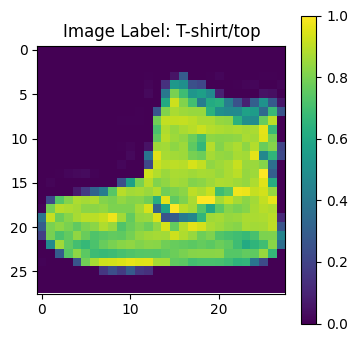

In [10]:
show_indiv_image(x_train, 0, 0)

Lastly, for this section we will apply one-hot encoding to the target variables

In [11]:
print(f"Training set shape for Target variable pre-OHE: {y_train.shape}")
print(f"Training set shape for Target variable pre-OHE: {y_test.shape}")

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f"Training set shape for Target variable post-OHE: {y_train.shape}")
print(f"Training set shape for Target variable post-OHE: {y_test.shape}")

Training set shape for Target variable pre-OHE: (60000,)
Training set shape for Target variable pre-OHE: (10000,)
Training set shape for Target variable post-OHE: (60000, 10)
Training set shape for Target variable post-OHE: (10000, 10)


In [12]:
y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## Part 3: Build the Model

In [13]:
num_classes = y_train.shape[1]

In [14]:
# set random seeds
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

We'll split the training set into two sets: one for training (80% of the training dataset) and one for validation (remaining 20%). This is to avoid overfitting when we evaluate the model using the test set.

Additionally, we'll also then apply cross-validation using 5 folds.

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

We initate our neural network model by calling `Sequential()` to store our linear stack of layers.

We then proceed to add the following layers:
1. `Conv2D`: this is a 2D convolutional layer with 64 filters and a kernel size of 3 x 3
    - each of the 64 filters (or kernels) will slide over each input image computing a dot product between the kernel and the input at each position.
    - as a result, we get 64 feature maps which the ReLU activation finction will be applied resulting in the negative values in these feature maps to be set to 0.
    - these 64 feature maps are combined into a single 3D tensor which will be fed to the next layer
2. `BatchNormalization`: normalizes and scales the 3D tensor from the previous layer
    - the purpose of batch normalization is to stablize and accelerate training
    - the output tensor from this layer is then fed into the next layer, while maintaing the same shape but with normalized values
3. `MaxPooling2D`: 

In [16]:
def build_model(hp):
    model = Sequential()
    
    # Tuning the number of conv layers (1-3)
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(
            filters=hp.Int(f'conv_{i}_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'conv_{i}_kernel', values=[3, 5]),
            activation='relu',
            input_shape=(28, 28, 1) if i == 0 else None
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Tuning the number of dense layers (1-2)
    for i in range(hp.Int('num_dense_layers', 1, 2)):
        model.add(Dense(
            units=hp.Int(f'dense_{i}_units', min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Tuning the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Combine training and validation data for cross-validation
x_train_full = np.concatenate((x_train, x_val), axis=0)
y_train_full = np.concatenate((y_train, y_val), axis=0)

# Define the K-Fold cross-validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Custom Tuner class with cross-validation
class CVTuner(kt.RandomSearch):
    def run_trial(self, trial, x, y, **kwargs):
        val_scores = []
        for train, val in kfold.split(x, y):
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(
                x[train], y[train],
                epochs=30,
                validation_data=(x[val], y[val]),
                **kwargs
            )
            val_scores.append(model.evaluate(x[val], y[val])[1])  # Get accuracy
        return np.mean(val_scores)

# Create and run the tuner
tuner = CVTuner(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir',
    project_name='fashion_mnist_tuning_cv'
)

tuner.search(x_train, y_train,
             verbose=1)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_model(best_hps)

# Train the best model on x_train and validate on x_val
history = best_model.fit(x_train, y_train, 
                         epochs=30, 
                         validation_data=(x_val, y_val),
                         callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5)])

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on the test set
test_scores = best_model.evaluate(x_test, y_test, verbose=2)
print(f"Final test accuracy: {test_scores[1]*100:.2f}%")

Trial 2 Complete [00h 00m 01s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1                 |3                 |num_conv_layers
128               |128               |conv_0_filters
3                 |3                 |conv_0_kernel
2                 |2                 |num_dense_layers
128               |128               |dense_0_units
0.4               |0.3               |dropout_0
0.00060681        |0.0010088         |learning_rate
32                |32                |conv_1_filters
3                 |3                 |conv_1_kernel
64                |32                |conv_2_filters
3                 |3                 |conv_2_kernel
256               |64                |dense_1_units
0.4               |0.2               |dropout_1



Traceback (most recent call last):
  File "/Users/eugene/Github/Image-Classifier-Fashion-MNIST/venv/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/eugene/Github/Image-Classifier-Fashion-MNIST/venv/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_6685/2412668563.py", line 52, in run_trial
    model.fit(
TypeError: keras.src.backend.tensorflow.trainer.TensorFlowTrainer.fit() got multiple values for keyword argument 'epochs'


RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/eugene/Github/Image-Classifier-Fashion-MNIST/venv/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/eugene/Github/Image-Classifier-Fashion-MNIST/venv/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_6685/2412668563.py", line 52, in run_trial
    model.fit(
TypeError: keras.src.backend.tensorflow.trainer.TensorFlowTrainer.fit() got multiple values for keyword argument 'epochs'


In [ ]:
# Evaluating the Quality of the System
# Predict probabilities
y_pred_proba = best_model.predict(x_test)
# Convert to class labels
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")

In [ ]:
# Analyzing Errors with Confusion Matrix
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Assuming 'conv2d_1' is the name of the last convolutional layer
last_conv_layer_name = "conv2d_1"

# Generate Grad-CAM for multiple examples
num_examples = 5
plt.figure(figsize=(20, 4*num_examples))
for i in range(num_examples):
    sample_image = x_test[i]
    heatmap = make_gradcam_heatmap(sample_image[np.newaxis, ...], best_model, last_conv_layer_name)
    
    plt.subplot(num_examples, 2, 2*i+1)
    plt.imshow(sample_image.reshape(28, 28), cmap='gray')
    plt.title(f'Original Image (True: {class_names[y_true[i]]}, Pred: {class_names[y_pred[i]]})')
    
    plt.subplot(num_examples, 2, 2*i+2)
    plt.imshow(heatmap, cmap='viridis')
    plt.title('Grad-CAM Heatmap')

plt.tight_layout()
plt.show()

In [ ]:
break

In [ ]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_no = 1
cv_scores = []
best_model = None
best_accuracy = 0

for train, val in kfold.split(x_train, y_train):
    # Create and compile the model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train[train], y_train[train], 
                        validation_data=(x_train[val], y_train[val]), 
                        epochs=50, batch_size=200, verbose=2, callbacks=[early_stopping])
    
    # Evaluate the model on the validation fold
    scores = model.evaluate(x_train[val], y_train[val], verbose=2)
    print(f'Fold {fold_no}: Accuracy = {scores[1]*100:.2f}%')
    print()
    cv_scores.append(scores[1] * 100)

    # Keep track of the best model
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_model = model
    
    fold_no += 1

# Print the average accuracy across all folds
print(f'Average cross-validation accuracy: {np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)')
print()


In [ ]:
# use the best model from cross-validation as a starting point
final_model = Sequential()
final_model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'))
final_model.add(BatchNormalization())
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Conv2D(128, (3, 3), activation='relu'))
final_model.add(BatchNormalization())
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Dropout(0.3))
final_model.add(Flatten())
final_model.add(Dense(256, activation='relu'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.4))
final_model.add(Dense(num_classes, activation='softmax'))

final_model.set_weights(best_model.get_weights())
final_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the final model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
final_history = final_model.fit(x_train, y_train, 
                                validation_data=(x_val, y_val), 
                                epochs=50, batch_size=200, verbose=2, 
                                callbacks=[early_stopping])

# Evaluate on the test set
test_scores = final_model.evaluate(x_test, y_test, verbose=2)
print(f"Final test accuracy: {test_scores[1]*100:.2f}%")

In [ ]:
# Define the Hypermodel
def build_model(hp):
    model = Sequential()
    
    # Tuning the number of conv layers (1-3)
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(
            filters=hp.Int(f'conv_{i}_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'conv_{i}_kernel', values=[3, 5]),
            activation='relu',
            input_shape=(28, 28, 1) if i == 0 else None
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Tuning the number of dense layers (1-2)
    for i in range(hp.Int('num_dense_layers', 1, 2)):
        model.add(Dense(
            units=hp.Int(f'dense_{i}_units', min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Tuning the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Create and Run the Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,  # number of different configurations to try
    executions_per_trial=2,  # number of times to train each configuration
    directory='my_dir',
    project_name='fashion_mnist_tuning'
)

tuner.search(x_train, y_train,
             epochs=50,
             validation_data=(x_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights=True)])


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

# Fine-tune the best model on the entire training set
best_model.fit(x_train, y_train, 
               validation_data=(x_val, y_val), 
               epochs=20, batch_size=200, verbose=2, 
               callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5)])

# Evaluate on the test set
test_scores = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Final test accuracy: {test_scores[1]*100:.2f}%")


In [ ]:
# Evaluating the Quality of the System
# Predict probabilities
y_pred_proba = best_model.predict(x_test)
# Convert to class labels
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")

In [ ]:
# Analyzing Errors with Confusion Matrix
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
break

In [ ]:
# model = Sequential()
# model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))
# model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# model.summary()

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=200, verbose=2, callbacks=[early_stopping])

# scores = model.evaluate(x_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))